In [ ]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
CATEGORICAL_COLUMNS = ['MSSubClass', 'MSZoning']
NUMERIC_COLUMNS = ['LotFrontage', 'LotArea','OverallQual','OverallCond']

In [ ]:
housePrices=pd.read_csv('train.csv')

In [ ]:
housePrices = housePrices[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'OverallQual','OverallCond', 'SalePrice']]

In [ ]:
housePrices.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,OverallQual,OverallCond,SalePrice
0,60,RL,65.0,8450,Reg,7,5,208500
1,20,RL,80.0,9600,Reg,6,8,181500
2,60,RL,68.0,11250,IR1,7,5,223500
3,70,RL,60.0,9550,IR1,7,5,140000
4,60,RL,84.0,14260,IR1,8,5,250000


In [ ]:
housePrices['LotFrontage'].fillna(housePrices['LotFrontage'].mean(), inplace=True)
housePrices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1460 non-null   object 
 1   MSZoning     1460 non-null   object 
 2   LotFrontage  1460 non-null   float64
 3   LotArea      1460 non-null   int64  
 4   LotShape     1460 non-null   object 
 5   OverallQual  1460 non-null   int64  
 6   OverallCond  1460 non-null   int64  
 7   SalePrice    1460 non-null   int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 91.4+ KB


In [ ]:
housePrices['MSSubClass'] = housePrices['MSSubClass'].astype(str) 

In [ ]:
housePrices.dtypes

MSSubClass      object
MSZoning        object
LotFrontage    float64
LotArea          int64
LotShape        object
OverallQual      int64
OverallCond      int64
SalePrice        int64
dtype: object

In [ ]:
train, test = train_test_split(housePrices, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

934 train examples
234 validation examples
292 test examples


In [ ]:
housePrices_features = train.copy()
housePrices_labels = housePrices_features.pop('SalePrice')
housePrices_labels = housePrices_labels/100000

val_features = val.copy()
val_labels = val.pop('SalePrice')
val_labels = val_labels/100000

In [ ]:
print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

MSSubClass      object
MSZoning        object
LotFrontage    float64
LotArea          int64
LotShape        object
OverallQual      int64
OverallCond      int64
dtype: object
float64


In [ ]:
inputs = {}

for name, column in housePrices_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'MSSubClass': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MSSubClass')>,
 'MSZoning': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'MSZoning')>,
 'LotFrontage': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'LotFrontage')>,
 'LotArea': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'LotArea')>,
 'LotShape': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'LotShape')>,
 'OverallQual': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'OverallQual')>,
 'OverallCond': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'OverallCond')>}

In [ ]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(housePrices[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'normalization_1')>

In [ ]:
preprocessed_inputs = [all_numeric_inputs]

In [ ]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(housePrices_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

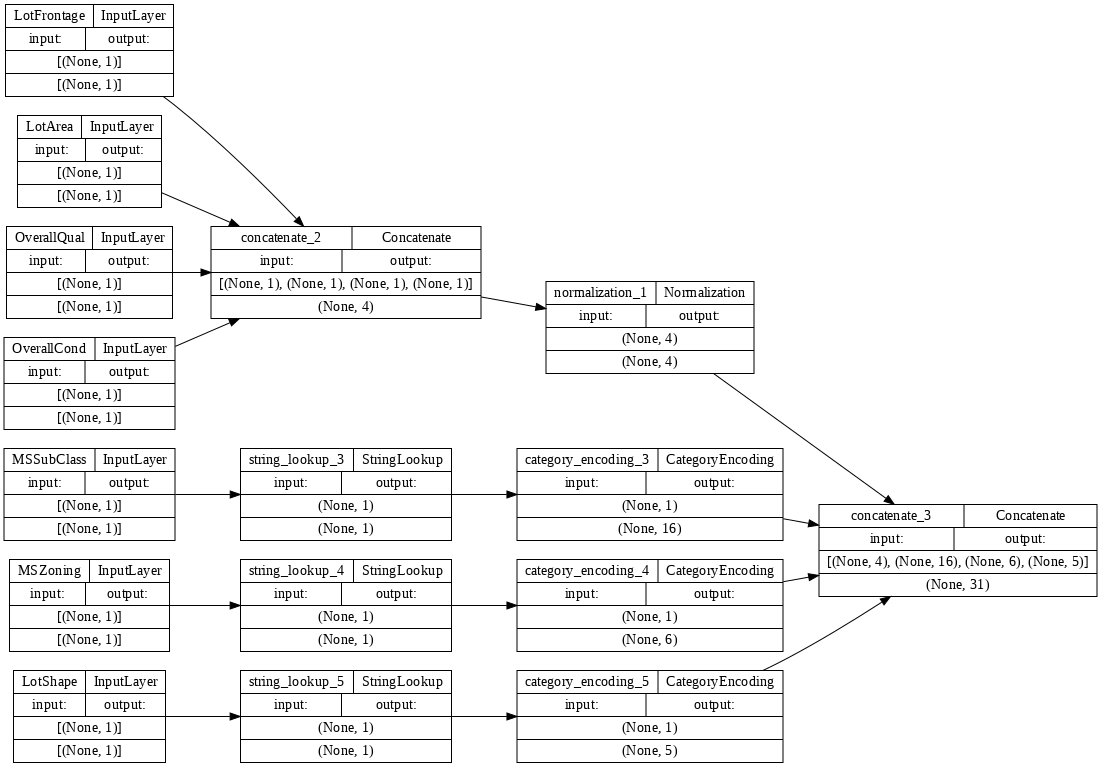

In [ ]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

In [ ]:
housePrices_features_dict = {name: np.array(value) 
                         for name, value in housePrices_features.items()}

In [ ]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}
housePrices_preprocessing(features_dict)

<tf.Tensor: shape=(1, 31), dtype=float32, numpy=
array([[1.179, 0.076, 0.651, 1.281, 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   ,
        0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 1.   , 0.   , 0.   ,
        0.   , 0.   , 0.   , 1.   ]], dtype=float32)>

In [ ]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

In [ ]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = housePrices_model.fit(x=housePrices_features_dict, y=housePrices_labels,epochs=250,
                        validation_data=(val_features_dict, val_labels))

Epoch 1/250
30/30 [==============================] - 1s 15ms/step - loss: 1.2718 - mae: 0.8117 - val_loss: 0.4649 - val_mae: 0.4635
Epoch 2/250
30/30 [==============================] - 0s 5ms/step - loss: 0.3318 - mae: 0.3469 - val_loss: 0.1980 - val_mae: 0.2849
Epoch 3/250
30/30 [==============================] - 0s 4ms/step - loss: 0.2436 - mae: 0.3063 - val_loss: 0.1814 - val_mae: 0.2655
Epoch 4/250
30/30 [==============================] - 0s 4ms/step - loss: 0.2152 - mae: 0.2891 - val_loss: 0.1680 - val_mae: 0.2563
Epoch 5/250
30/30 [==============================] - 0s 4ms/step - loss: 0.1988 - mae: 0.2748 - val_loss: 0.1643 - val_mae: 0.2558
Epoch 6/250
30/30 [==============================] - 0s 4ms/step - loss: 0.1867 - mae: 0.2624 - val_loss: 0.1624 - val_mae: 0.2552
Epoch 7/250
30/30 [==============================] - 0s 4ms/step - loss: 0.1796 - mae: 0.2601 - val_loss: 0.1537 - val_mae: 0.2456
Epoch 8/250
30/30 [==============================] - 0s 4ms/step - loss: 0.1778 - 

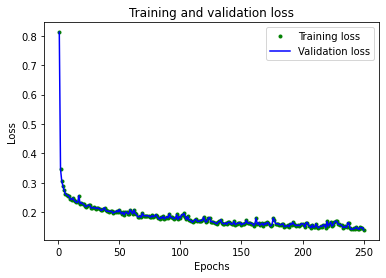

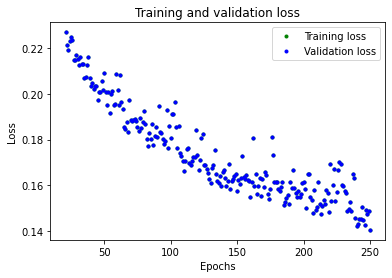

In [ ]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test = pd.read_csv('test.csv')

In [ ]:
test = test[['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'OverallQual','OverallCond']]

In [ ]:
test['MSSubClass'] = test['MSSubClass'].astype(str) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
dict(test.iloc[0])

{'MSSubClass': '20',
 'MSZoning': 'RH',
 'LotFrontage': 80.0,
 'LotArea': 11622,
 'LotShape': 'Reg',
 'OverallQual': 5,
 'OverallCond': 6}

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSSubClass   1459 non-null   object 
 1   MSZoning     1459 non-null   object 
 2   LotFrontage  1459 non-null   float64
 3   LotArea      1459 non-null   int64  
 4   LotShape     1459 non-null   object 
 5   OverallQual  1459 non-null   int64  
 6   OverallCond  1459 non-null   int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 79.9+ KB


In [ ]:
test['MSZoning'].fillna('RL', inplace=True)
test['LotFrontage'].fillna(test['LotFrontage'].mean(), inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
value = {'MSSubClass': np.array(test['MSSubClass']),
 'MSZoning': np.array(test['MSZoning']),
 'LotFrontage': np.array(test['LotFrontage']),
 'LotArea': np.array(test['LotArea']),
 'LotShape': np.array(test['LotShape']),
 'OverallQual': np.array(test['OverallQual']),
 'OverallCond': np.array(test['OverallCond'])}

In [ ]:
ans = housePrices_model.predict(value)

In [ ]:
print(ans)

[[142103.69]
 [179504.78]
 [160893.45]
 ...
 [214201.77]
 [131329.5 ]
 [236105.56]]


In [ ]:
ans *= 100000

In [ ]:
ans.shape

(1459, 1)

In [ ]:
final_data = pd.DataFrame(data={'SalePrice': [num[0] for num in list(ans)]})

In [ ]:
final_data.to_csv('submission.csv')